In [19]:
import pickle
import os
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Read pkls
temperature_file = r'D:\Savant\Data\ALL_5min_TEMPS.pkl'
data = pd.read_pickle(temperature_file)
data.index = data.index.tz_localize('UTC')

In [22]:
# Create a df with sunrise and sunset times
# Note: This code assumes that the Savant data is in UTC and that the local timezone is US/Central.
from suntime import Sun
lat, lon = 40.211, -88.406 # three decimals for ~100 m accuracy
savant_date_range = data.index
date_range = pd.date_range(start=savant_date_range[0], end=savant_date_range[-1], freq='D')
sun = Sun(lat, lon)
sunrise_times = []
sunset_times = []
for date in date_range:
    sunrise = sun.get_local_sunrise_time(date)
    sunset = sun.get_local_sunset_time(date)
    sunrise_times.append(sunrise)
    sunset_times.append(sunset)
# Create a DataFrame with sunrise and sunset times
sun_times = pd.DataFrame({
    'date': date_range.date,
    'sunrise': sunrise_times,
    'sunset': sunset_times
})
sun_times['sunrise'] = sun_times['sunrise'].dt.tz_localize('UTC')
sun_times['sunset'] = sun_times['sunset'].dt.tz_localize('UTC')
sun_times['sunrise_local'] = sun_times['sunrise'].dt.tz_convert('US/Central')
sun_times['sunset_local'] = sun_times['sunset'].dt.tz_convert('US/Central')
sun_times

# find the earliest and latest times in the data by converting to time detla and finding time after 00:00
sunrise_times = sun_times['sunrise'].dt.time
sunrise_times = pd.to_timedelta(sunrise_times.astype(str)).dt.total_seconds() / 3600 # convert to hours

earliest_sunrise = min(sunrise_times)
latest_sunrise = max(sunrise_times)
avg_sunrise = sum(sunrise_times)/len(sunrise_times) # average sunrise time in hours

sunset_times = sun_times['sunset'] + pd.Timedelta(hours=12) # add 12 hours to sunset times to avoid issues with midnight
sunset_times = sunset_times.dt.time
sunset_times = pd.to_timedelta(sunset_times.astype(str)).dt.total_seconds() / 3600 # convert to hours

earliest_sunset = min(sunset_times) +12 # add 12 hours to get the correct time
latest_sunset = max(sunset_times) - 12 # subtract 12 hours to get the correct time
avg_sunset = (sum(sunset_times) / len(sunset_times)) +12 # average sunset time in hours

print(f'Average sunrise: {avg_sunrise:.2f}, average sunset: {avg_sunset:.2f}')
print(f'Earliest sunrise: {earliest_sunrise:.2f}, latest sunrise: {latest_sunrise:.2f}')
print(f'Earliest sunset: {earliest_sunset:.2f}, latest sunset: {latest_sunset:.2f} ') # Issues here with UTC time at zero. 


Average sunrise: 12.19, average sunset: 23.17
Earliest sunrise: 11.53, latest sunrise: 12.90
Earliest sunset: 22.49, latest sunset: 0.13 


In [23]:
init = data[[c for c in data.columns if 'init' in c]].copy()
rel = data[[c for c in data.columns if 'rel' in c]].copy()
uconv = data[[c for c in data.columns if 'uconv' in c]].copy()
lconv = data[[c for c in data.columns if 'lcon' in c]].copy()

print(init.columns)
print(rel.columns)
print(uconv.columns)
print(lconv.columns)

Index(['T_1_5m_init', 'T_4_5m_init', 'T_10m_init', 'T_0_2m_init'], dtype='object')
Index(['T_1_5m_rel', 'T_4_5m_rel', 'T_20m_rel', 'T_0_2m_rel', 'T_15m_rel',
       'T_8_5m_rel'],
      dtype='object')
Index(['T_1_5m_uconv', 'T_4_5m_uconv', 'T_10m_uconv', 'T_0_2m_uconv'], dtype='object')
Index(['T_1_5m_lconv', 'T_4_5m_lconv', 'T_10m_lconv', 'T_0_2m_lconv',
       'T_8_5m_lconv', 'T_20m_lconv'],
      dtype='object')


In [24]:
init['lapse_10_to_1_5'] = ((init['T_10m_init'] - init['T_1_5m_init']) /(10-1.5)) 
rel['lapse_8_5_to_1_5'] = ((rel['T_8_5m_rel'] - rel['T_1_5m_rel']) /(8.5-1.5))    
uconv['lapse_10_to_1_5'] = ((uconv['T_10m_uconv'] - uconv['T_1_5m_uconv']) /(10-1.5))
lconv['lapse_8_5_to_1_5'] = ((lconv['T_8_5m_lconv'] - lconv['T_1_5m_lconv']) /(10-1.5))


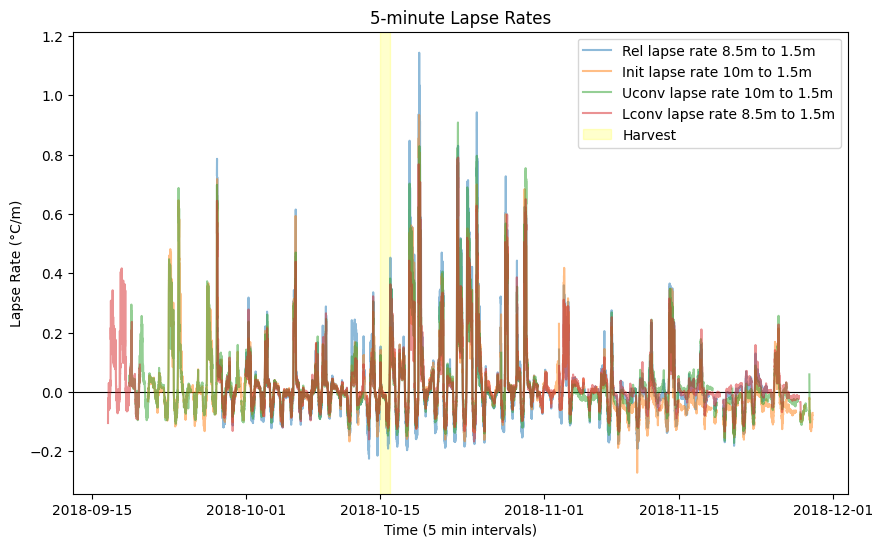

In [25]:
plt.figure(figsize=(10, 6))
plt.axhline(y=0, color='black', linewidth=0.8)
plt.plot(rel['lapse_8_5_to_1_5'], label='Rel lapse rate 8.5m to 1.5m', alpha=0.5)
plt.plot(init['lapse_10_to_1_5'], label='Init lapse rate 10m to 1.5m', alpha=0.5)       
plt.plot(uconv['lapse_10_to_1_5'], label='Uconv lapse rate 10m to 1.5m', alpha=0.5)
plt.plot(lconv['lapse_8_5_to_1_5'], label='Lconv lapse rate 8.5m to 1.5m', alpha=0.5)
plt.axvspan(pd.to_datetime('2018-10-15'), pd.to_datetime('2018-10-16'), color='yellow', alpha=0.2, label='Harvest')

# plt.xlim(pd.to_datetime('2018-10-12'),pd.to_datetime('2018-10-18')) # Alter times to look at specific time periods

plt.title('5-minute Lapse Rates')    
plt.xlabel('Time (5 min intervals)')
plt.ylabel('Lapse Rate (°C/m)')
plt.legend()
plt.show()

In [26]:
# for each df rename the lapse rate column
init.rename(columns={'lapse_10_to_1_5':'init_lapse_rate'}, inplace=True)
rel.rename(columns={'lapse_8_5_to_1_5':'rel_lapse_rate'}, inplace=True)
uconv.rename(columns={'lapse_10_to_1_5':'uconv_lapse_rate'}, inplace=True)
lconv.rename(columns={'lapse_8_5_to_1_5':'lconv_lapse_rate'}, inplace=True)

dfs = [init['init_lapse_rate'], rel['rel_lapse_rate'], uconv['uconv_lapse_rate'], lconv['lconv_lapse_rate']]
# Merge all dfs into one
lapse_rates = pd.concat(dfs, axis=1)

In [27]:
lapse_rates

,init_lapse_rate,rel_lapse_rate,uconv_lapse_rate,lconv_lapse_rate
Timestamp,,,,
2018-09-12 00:02:30+00:00,NaN,NaN,NaN,NaN
2018-09-12 00:07:30+00:00,NaN,NaN,NaN,NaN
2018-09-12 00:12:30+00:00,NaN,NaN,NaN,NaN
2018-09-12 00:17:30+00:00,NaN,NaN,NaN,NaN
2018-09-12 00:22:30+00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2018-11-28 20:52:30+00:00,-0.078950,NaN,NaN,NaN
2018-11-28 20:57:30+00:00,-0.077363,NaN,NaN,NaN
2018-11-28 21:02:30+00:00,-0.074389,NaN,NaN,NaN


In [28]:
lapse_rates.describe()

,init_lapse_rate,rel_lapse_rate,uconv_lapse_rate,lconv_lapse_rate
count,19029.000000,15298.000000,18695.000000,16924.000000
mean,0.012845,0.021981,0.024182,0.026824
std,0.114289,0.131284,0.116788,0.099395
min,-0.272140,-0.224934,-0.171947,-0.166920
25%,-0.049546,-0.039188,-0.032264,-0.020047
50%,-0.009648,-0.002194,-0.000834,0.004294
75%,0.031430,0.037467,0.035614,0.036889
max,0.933126,1.142967,1.032549,0.789822


In [29]:
lapse_rates

,init_lapse_rate,rel_lapse_rate,uconv_lapse_rate,lconv_lapse_rate
Timestamp,,,,
2018-09-12 00:02:30+00:00,NaN,NaN,NaN,NaN
2018-09-12 00:07:30+00:00,NaN,NaN,NaN,NaN
2018-09-12 00:12:30+00:00,NaN,NaN,NaN,NaN
2018-09-12 00:17:30+00:00,NaN,NaN,NaN,NaN
2018-09-12 00:22:30+00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2018-11-28 20:52:30+00:00,-0.078950,NaN,NaN,NaN
2018-11-28 20:57:30+00:00,-0.077363,NaN,NaN,NaN
2018-11-28 21:02:30+00:00,-0.074389,NaN,NaN,NaN


In [30]:
lapse_rates_melt = lapse_rates.melt(var_name='lapse_rate_type', value_name='lapse_rate', ignore_index=False)
target_date = pd.to_datetime('2018-10-10 00:22:30+00:00')
lapse_rates_melt.loc[target_date]

,lapse_rate_type,lapse_rate
Timestamp,,
2018-10-10 00:22:30+00:00,init_lapse_rate,0.029303
2018-10-10 00:22:30+00:00,rel_lapse_rate,0.044734
2018-10-10 00:22:30+00:00,uconv_lapse_rate,0.032132
2018-10-10 00:22:30+00:00,lconv_lapse_rate,0.034102


In [31]:
# add some variables to group by 
lapse_rates_melt['hour'] = lapse_rates_melt.index.hour
lapse_rates_melt['local_hour'] = lapse_rates_melt.index.tz_convert('US/Central').hour
lapse_rates_melt['minute'] = lapse_rates_melt.index.minute
lapse_rates_melt['day'] = lapse_rates_melt.index.day
lapse_rates_melt['month'] = lapse_rates_melt.index.month
lapse_rates_melt['year'] = lapse_rates_melt.index.year
lapse_rates_melt['date'] = lapse_rates_melt.index.date
lapse_rates_melt['week'] = lapse_rates_melt.index.isocalendar().week
lapse_rates_melt['weekday'] = lapse_rates_melt.index.weekday

# reset index to be unique and make old index a column
lapse_rates_melt.reset_index(inplace=True)
lapse_rates_melt

,Timestamp,lapse_rate_type,lapse_rate,hour,local_hour,minute,day,month,year,date,week,weekday
0,2018-09-12 00:02:30+00:00,init_lapse_rate,NaN,0,19,2,12,9,2018,2018-09-12,37,2
1,2018-09-12 00:07:30+00:00,init_lapse_rate,NaN,0,19,7,12,9,2018,2018-09-12,37,2
2,2018-09-12 00:12:30+00:00,init_lapse_rate,NaN,0,19,12,12,9,2018,2018-09-12,37,2
3,2018-09-12 00:17:30+00:00,init_lapse_rate,NaN,0,19,17,12,9,2018,2018-09-12,37,2
4,2018-09-12 00:22:30+00:00,init_lapse_rate,NaN,0,19,22,12,9,2018,2018-09-12,37,2
...,...,...,...,...,...,...,...,...,...,...,...,...
86263,2018-11-28 20:52:30+00:00,lconv_lapse_rate,NaN,20,14,52,28,11,2018,2018-11-28,48,2
86264,2018-11-28 20:57:30+00:00,lconv_lapse_rate,NaN,20,14,57,28,11,2018,2018-11-28,48,2
86265,2018-11-28 21:02:30+00:00,lconv_lapse_rate,NaN,21,15,2,28,11,2018,2018-11-28,48,2
86266,2018-11-28 21:07:30+00:00,lconv_lapse_rate,NaN,21,15,7,28,11,2018,2018-11-28,48,2


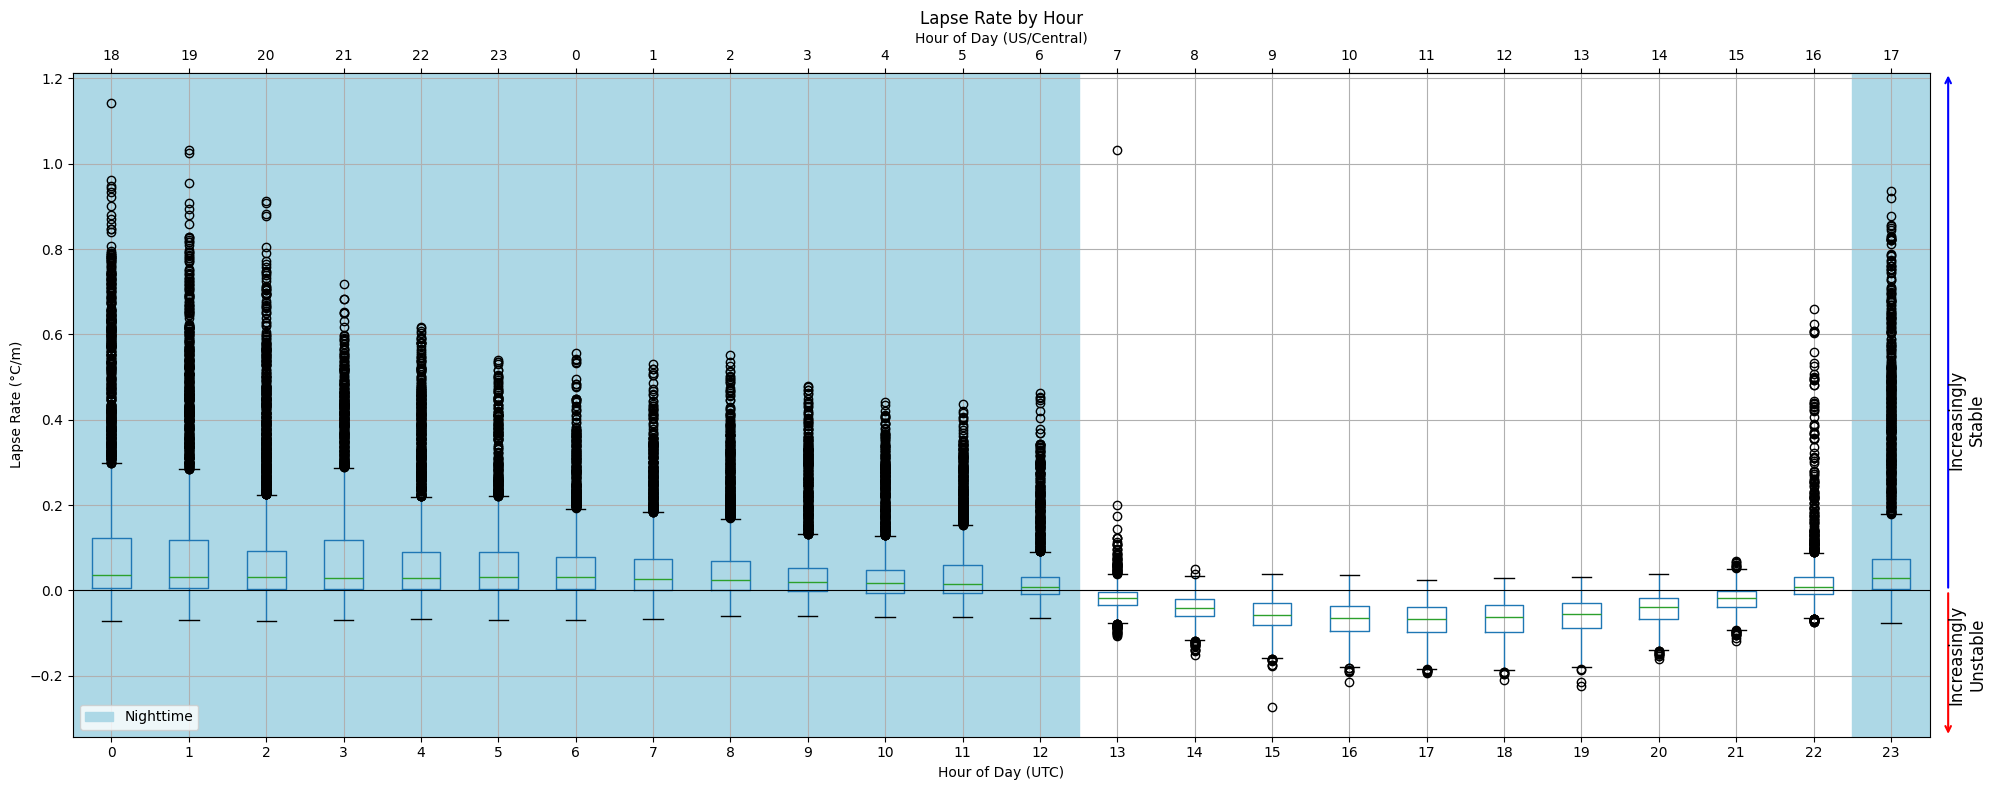

In [32]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the boxplots
grouped = lapse_rates_melt.groupby('hour')
labels = list(grouped.groups.keys())
grouped.boxplot(column='lapse_rate', subplots=False, ax=ax)

# Set main x-axis (UTC)
ax.set_xticks(range(1, len(labels)+1))
ax.set_xticklabels(labels)
ax.set_xlabel("Hour of Day (UTC)")
ax.set_ylabel("Lapse Rate (°C/m)")
ax.set_title("Lapse Rate by Hour")

# Define a function to convert UTC hour to US/Central hour
def utc_to_central(x):
    return [(hour - 6) % 24 for hour in x]  # Adjust for UTC-6, no DST

# Create secondary x-axis on top
secax = ax.secondary_xaxis('top')
secax.set_xticks(range(1, len(labels)+1))
secax.set_xticklabels(utc_to_central(labels))
secax.set_xlabel("Hour of Day (US/Central)")

# Add nighttime shading
night_hours_utc = list(range(0,13)) + list(range(23, 24))  # 0–5 and 23-23 UTC
for i, hour in enumerate(labels, start=1):  # Start at 1 because boxplot x-ticks start at 1
    if hour in night_hours_utc:
        ax.axvspan(i - 0.5, i + 0.5, color='lightblue')

# Add legend for nighttime shading
ax.fill_between([], [], color='lightblue', label=f'Nighttime')
ax.legend(loc='lower left')

# Horizontal line at y=0
plt.axhline(y=0, color='black', linewidth=0.8)  # Add a horizontal line at y=0

# Get current y-axis limits
ymin, ymax = ax.get_ylim()

# Add vertical arrow on the right side
ax.annotate(
    '', xy=(1.01, ymax), xytext=(1.01, 0),
    xycoords=('axes fraction', 'data'), textcoords=('axes fraction', 'data'),
    arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
)

# Add "Stable" label at the top of the arrow
ax.text(1.02, .4, 'Increasingly\nStable', va='center', ha='center', rotation=90,
        transform=ax.get_yaxis_transform(), fontsize=12)

# Add vertical arrow on the right side
ax.annotate(
    '', xy=(1.01, 0), xytext=(1.01, ymin),
    xycoords=('axes fraction', 'data'), textcoords=('axes fraction', 'data'),
    arrowprops=dict(arrowstyle='<-', color='red', lw=1.5),
)

# Add "Stable" label at the top of the arrow
ax.text(1.02, -0.15, 'Increasingly\nUnstable', va='center', ha='center', rotation=90,
        transform=ax.get_yaxis_transform(), fontsize=12)


plt.tight_layout()
plt.show()


In [33]:
# add some variables to group by 
lapse_rates['hour'] = lapse_rates.index.hour
lapse_rates['local_hour'] = lapse_rates.index.tz_convert('US/Central').hour
lapse_rates['minute'] = lapse_rates.index.minute
lapse_rates['day'] = lapse_rates.index.day
lapse_rates['month'] = lapse_rates.index.month
lapse_rates['year'] = lapse_rates.index.year
lapse_rates['date'] = lapse_rates.index.date
lapse_rates['week'] = lapse_rates.index.isocalendar().week
lapse_rates['weekday'] = lapse_rates.index.weekday

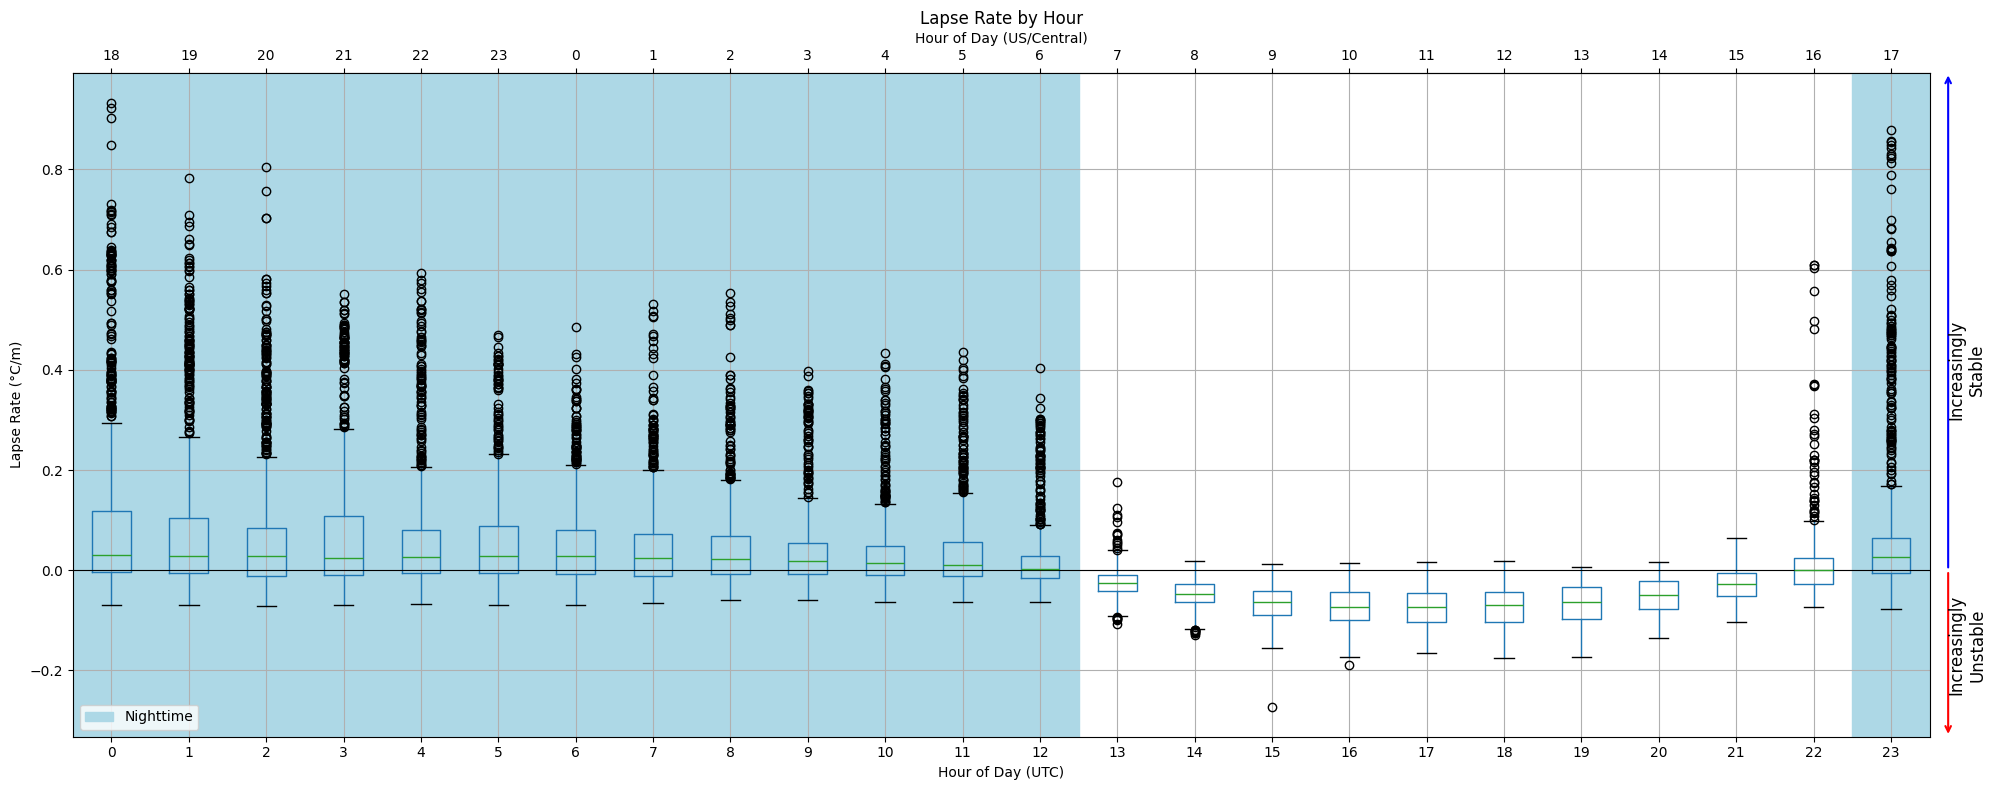

In [35]:
# Create a plot for all lapse rates
# Create figure and axis
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the boxplots
grouped = lapse_rates.groupby('hour')
labels = list(grouped.groups.keys())
grouped.boxplot(column='init_lapse_rate', subplots=False, ax=ax)

# Set main x-axis (UTC)
ax.set_xticks(range(1, len(labels)+1))
ax.set_xticklabels(labels)
ax.set_xlabel("Hour of Day (UTC)")
ax.set_ylabel("Lapse Rate (°C/m)")
ax.set_title("Lapse Rate by Hour")

# Define a function to convert UTC hour to US/Central hour
def utc_to_central(x):
    return [(hour - 6) % 24 for hour in x]  # Adjust for UTC-6, no DST

# Create secondary x-axis on top
secax = ax.secondary_xaxis('top')
secax.set_xticks(range(1, len(labels)+1))
secax.set_xticklabels(utc_to_central(labels))
secax.set_xlabel("Hour of Day (US/Central)")

# Add nighttime shading
night_hours_utc = list(range(0,13)) + list(range(23, 24))  # 0–5 and 23-23 UTC
for i, hour in enumerate(labels, start=1):  # Start at 1 because boxplot x-ticks start at 1
    if hour in night_hours_utc:
        ax.axvspan(i - 0.5, i + 0.5, color='lightblue')

# Add legend for nighttime shading
ax.fill_between([], [], color='lightblue', label=f'Nighttime')
ax.legend(loc='lower left')

# Horizontal line at y=0
plt.axhline(y=0, color='black', linewidth=0.8)  # Add a horizontal line at y=0

# Get current y-axis limits
ymin, ymax = ax.get_ylim()

# Add vertical arrow on the right side
ax.annotate(
    '', xy=(1.01, ymax), xytext=(1.01, 0),
    xycoords=('axes fraction', 'data'), textcoords=('axes fraction', 'data'),
    arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
)

# Add "Stable" label at the top of the arrow
ax.text(1.02, .4, 'Increasingly\nStable', va='center', ha='center', rotation=90,
        transform=ax.get_yaxis_transform(), fontsize=12)

# Add vertical arrow on the right side
ax.annotate(
    '', xy=(1.01, 0), xytext=(1.01, ymin),
    xycoords=('axes fraction', 'data'), textcoords=('axes fraction', 'data'),
    arrowprops=dict(arrowstyle='<-', color='red', lw=1.5),
)

# Add "Stable" label at the top of the arrow
ax.text(1.02, -0.15, 'Increasingly\nUnstable', va='center', ha='center', rotation=90,
        transform=ax.get_yaxis_transform(), fontsize=12)


plt.tight_layout()
plt.show()


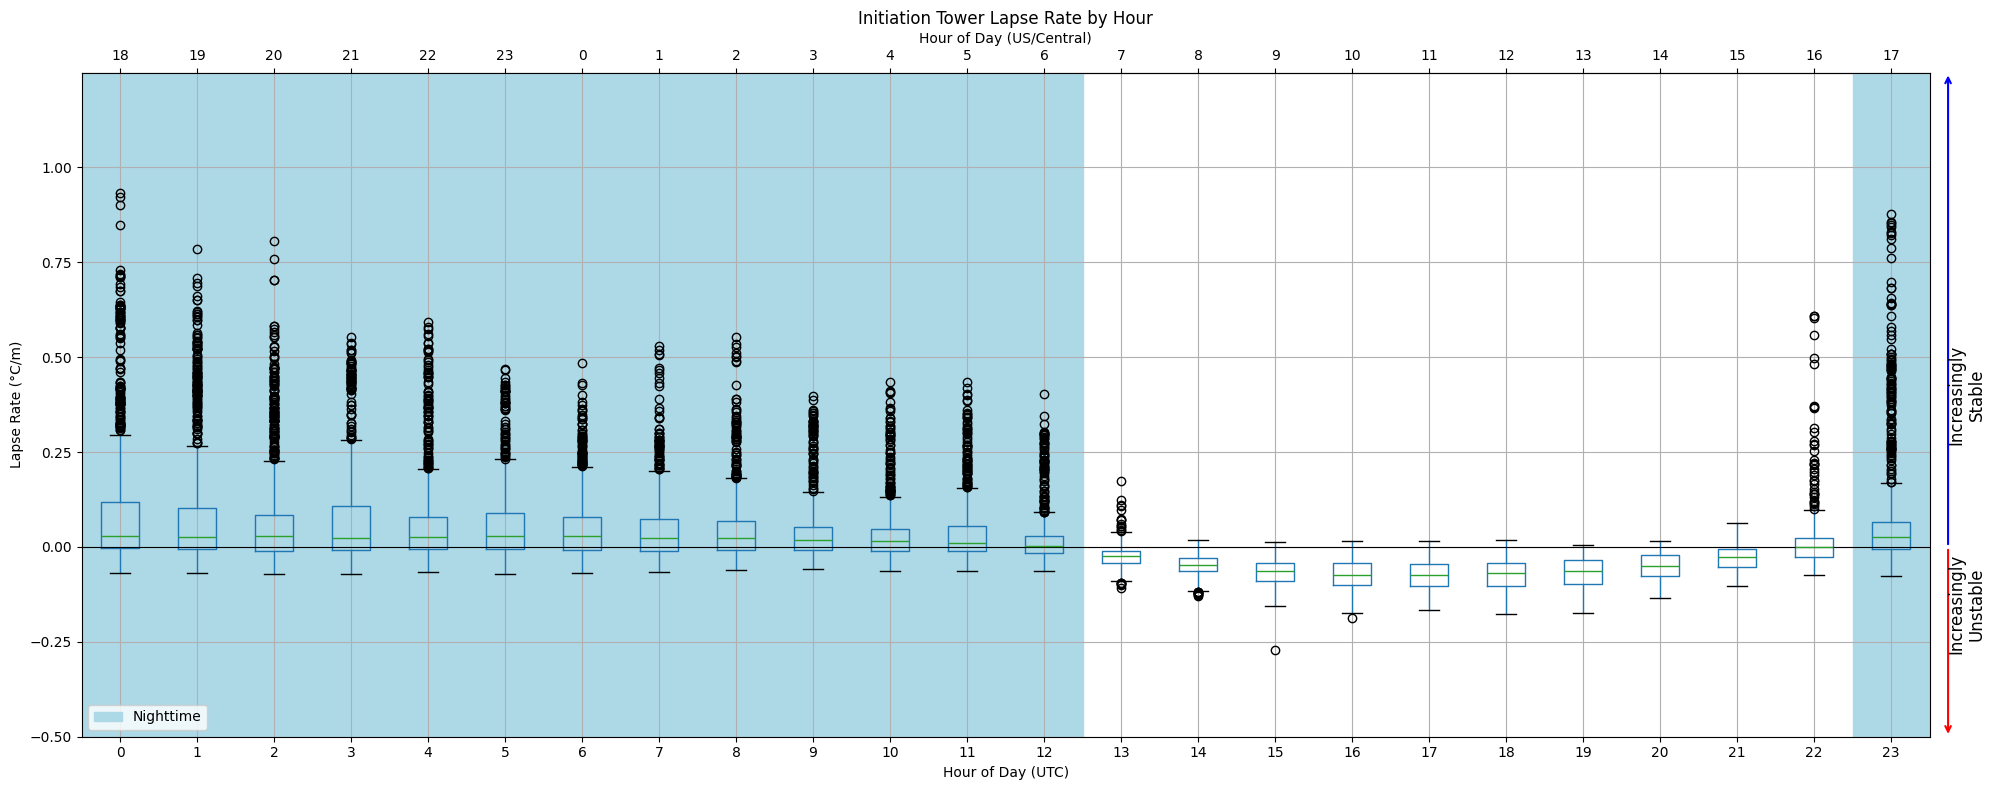

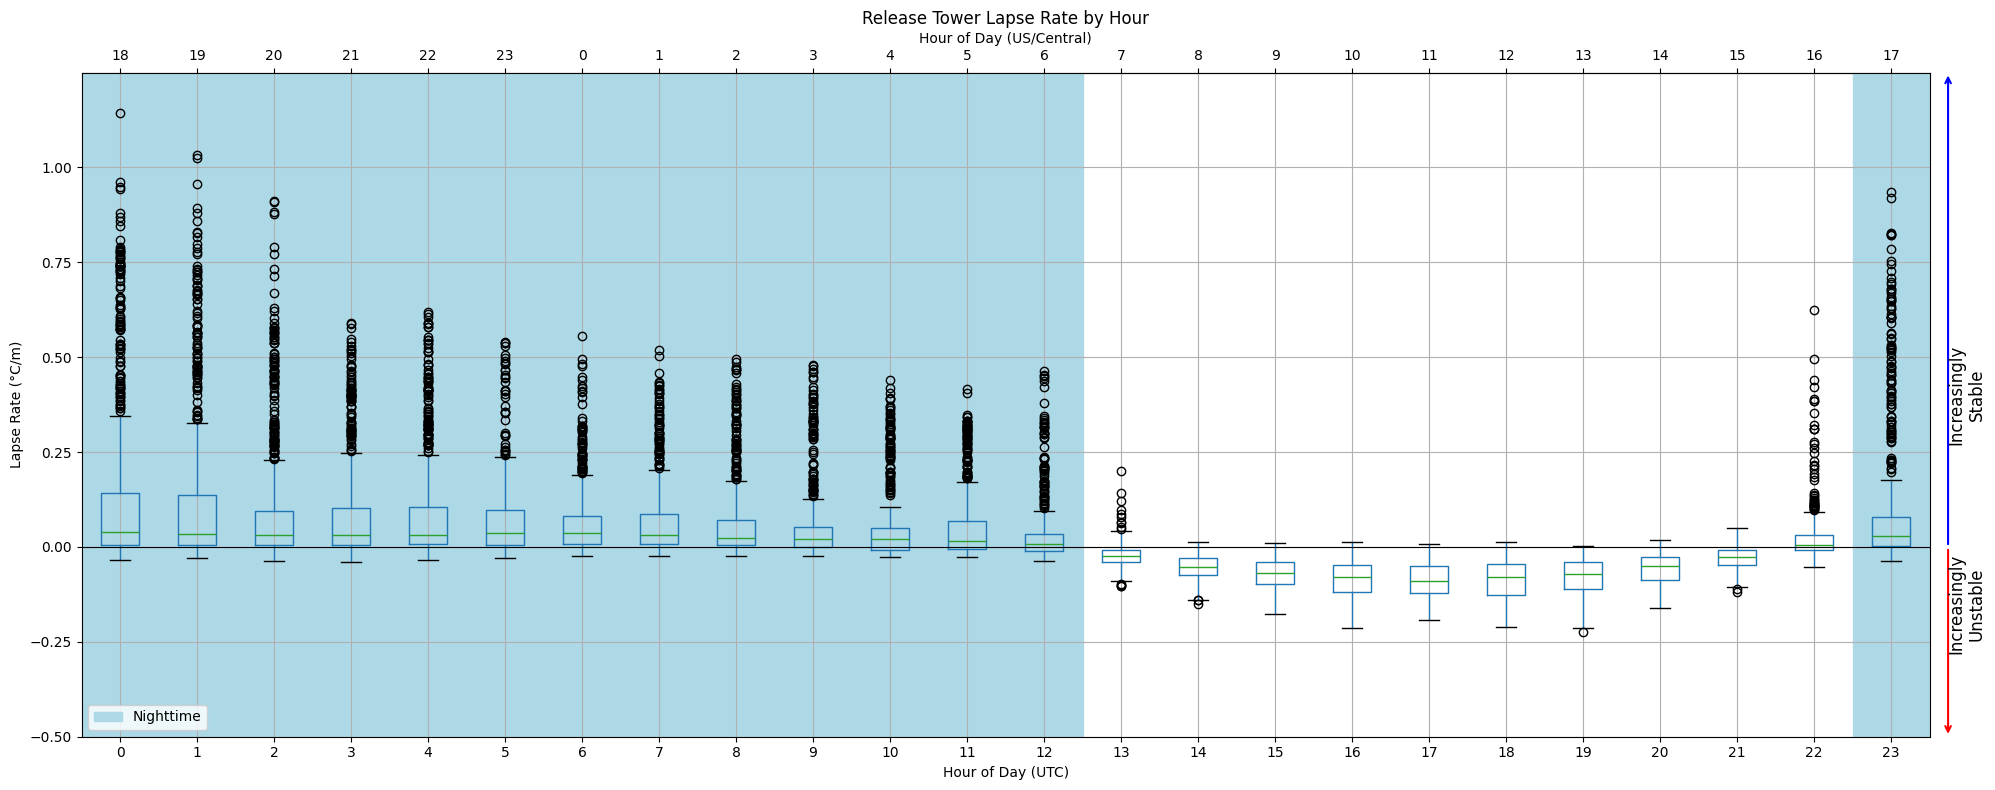

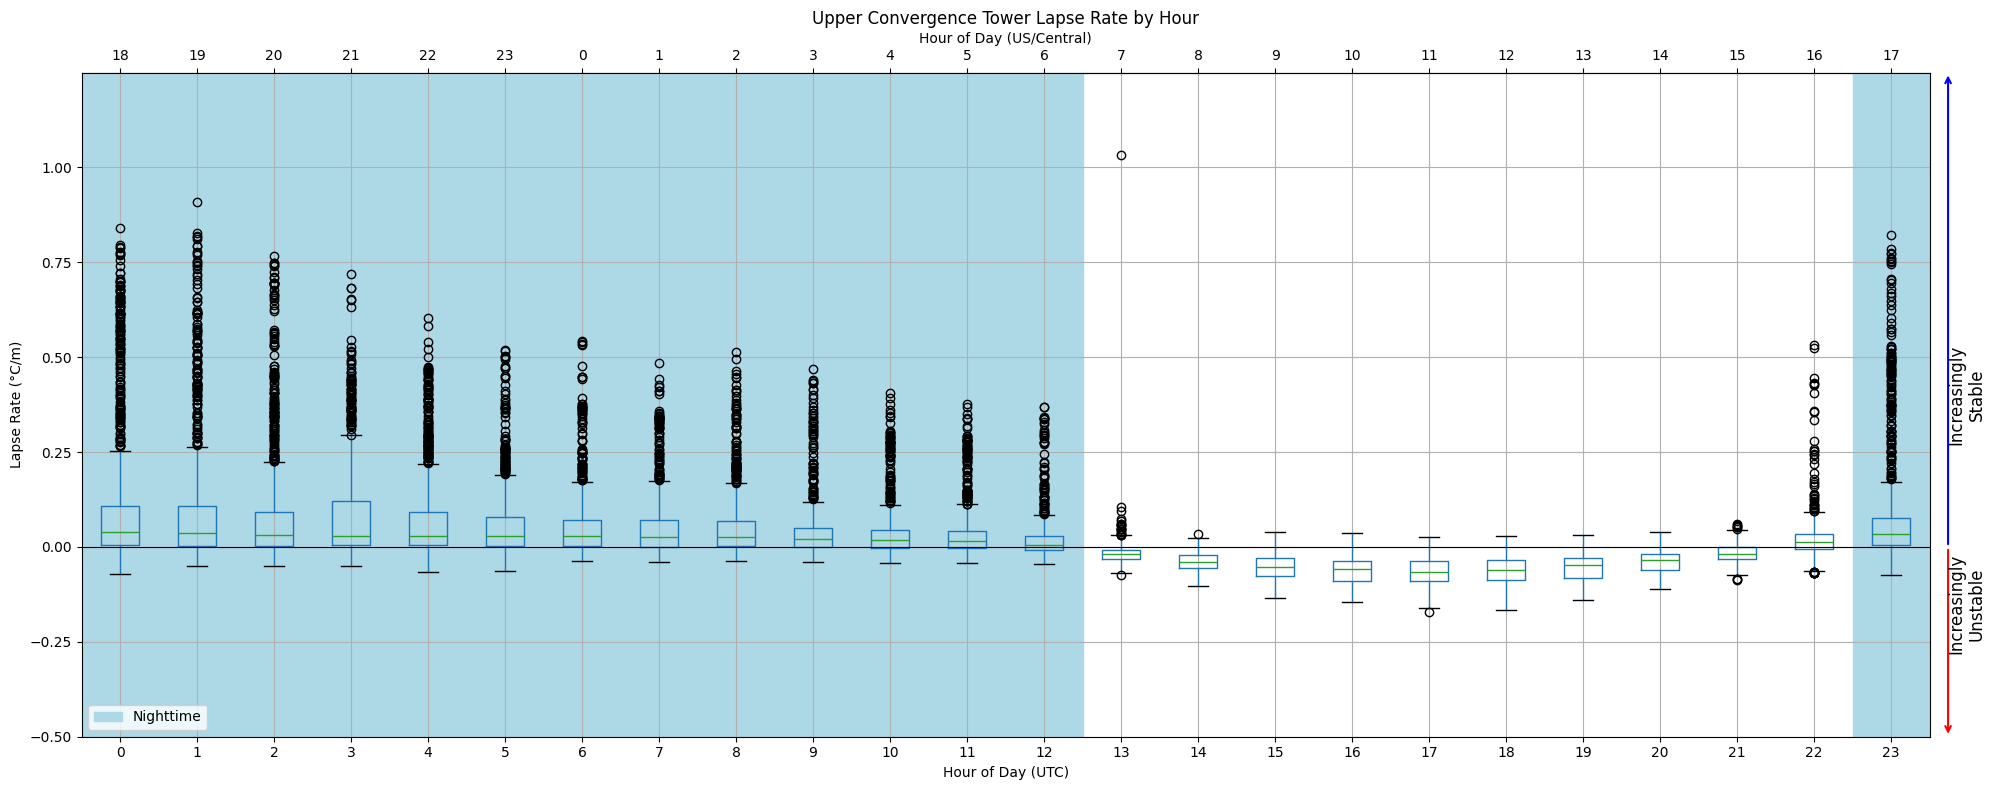

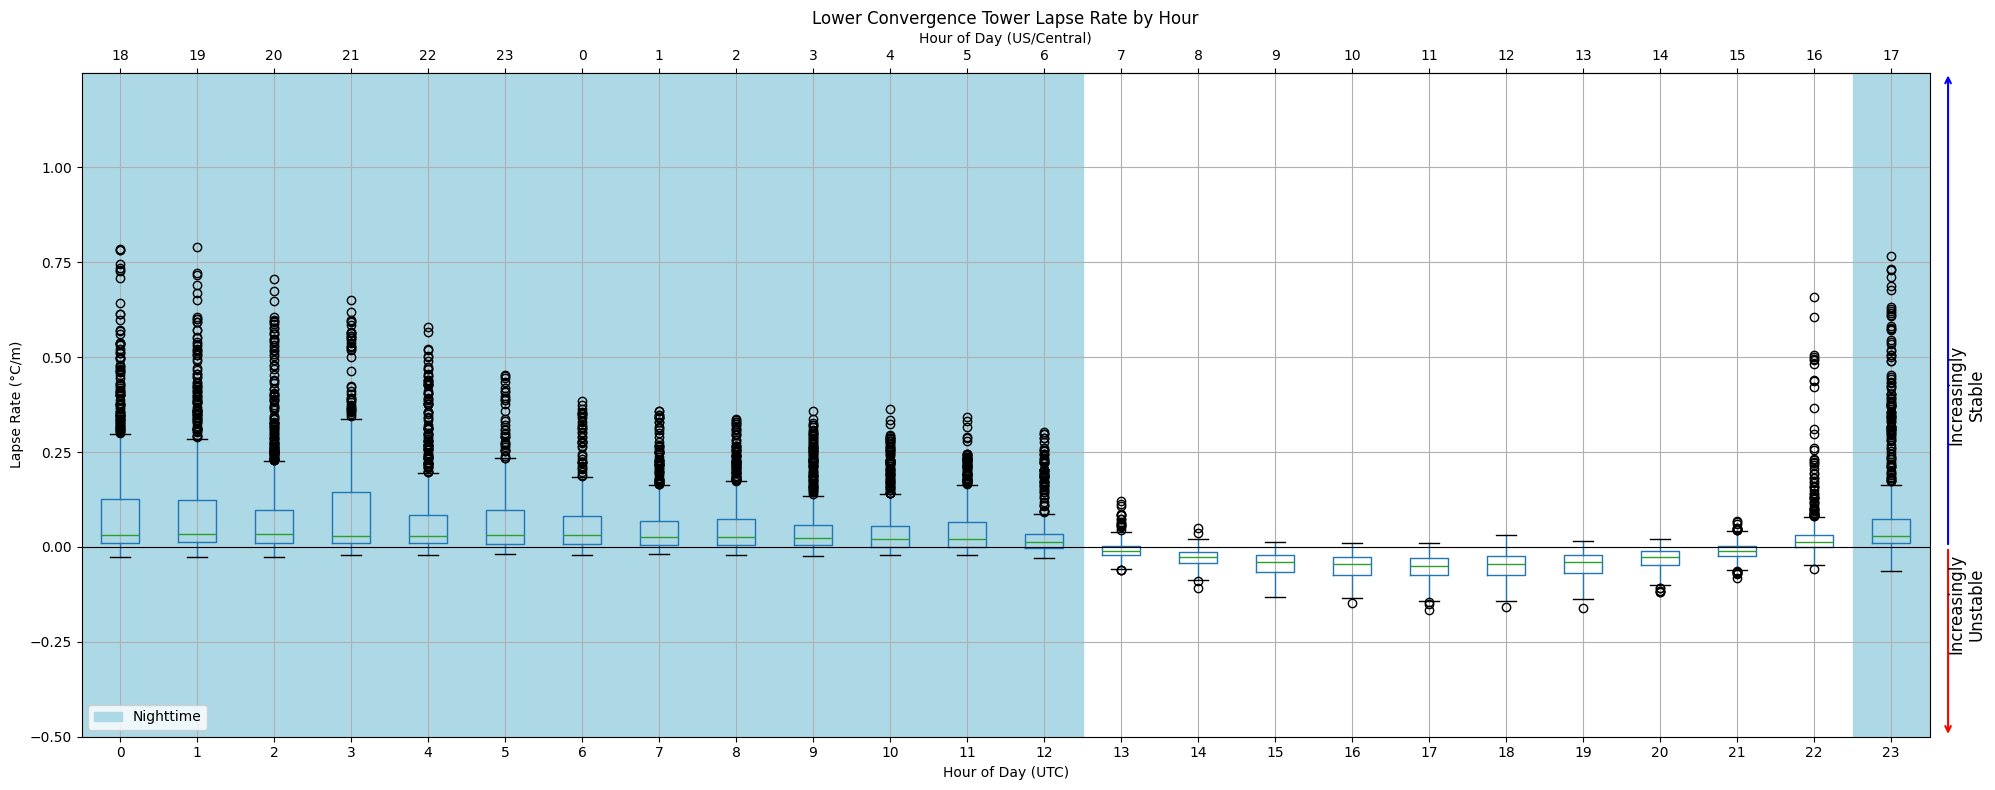

In [37]:
# Create a plot for each lapse rate location
# Create a dictionary to map location names to their corresponding Label
my_dict = {'init': 'Initiation Tower', 'rel': "Release Tower", 'uconv': "Upper Convergence Tower", 'lconv': "Lower Convergence Tower"}

for loc in my_dict.keys():
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(20, 8))
    # Plot the boxplots
    grouped = lapse_rates.groupby('hour')
    labels = list(grouped.groups.keys())
    grouped.boxplot(column=f'{loc}_lapse_rate', subplots=False, ax=ax)

    # Set main x-axis (UTC)
    ax.set_xticks(range(1, len(labels)+1))
    ax.set_xticklabels(labels)
    # set y-axis limits
    ax.set_ylim(-0.5, 1.25)  # Set y-axis limits to -0.5 to 0.5
    ax.set_yticks(np.arange(-0.5, 1.25, 0.25))  # Set y-ticks at intervals of 0.25

    # Set labels and title
    ax.set_xlabel("Hour of Day (UTC)")
    ax.set_ylabel("Lapse Rate (°C/m)")
    ax.set_title(f"{my_dict[loc]} Lapse Rate by Hour")

    # Define a function to convert UTC hour to US/Central hour
    def utc_to_central(x):
        return [(hour - 6) % 24 for hour in x]  # Adjust for UTC-6, no DST

    # Create secondary x-axis on top
    secax = ax.secondary_xaxis('top')
    secax.set_xticks(range(1, len(labels)+1))
    secax.set_xticklabels(utc_to_central(labels))
    secax.set_xlabel("Hour of Day (US/Central)")

    # Add nighttime shading
    night_hours_utc = list(range(0,13)) + list(range(23, 24))  # 0–5 and 23-23 UTC
    for i, hour in enumerate(labels, start=1):  # Start at 1 because boxplot x-ticks start at 1
        if hour in night_hours_utc:
            ax.axvspan(i - 0.5, i + 0.5, color='lightblue')

    # Add legend for nighttime shading
    ax.fill_between([], [], color='lightblue', label=f'Nighttime')
    ax.legend(loc='lower left')

    # Horizontal line at y=0
    plt.axhline(y=0, color='black', linewidth=0.8)  # Add a horizontal line at y=0

    # Get current y-axis limits
    ymin, ymax = ax.get_ylim()

    # Add vertical arrow on the right side
    ax.annotate(
        '', xy=(1.01, ymax), xytext=(1.01, 0),
        xycoords=('axes fraction', 'data'), textcoords=('axes fraction', 'data'),
        arrowprops=dict(arrowstyle='->', color='blue', lw=1.5),
    )

    # Add "Stable" label at the top of the arrow
    ax.text(1.02, .4, 'Increasingly\nStable', va='center', ha='center', rotation=90,
            transform=ax.get_yaxis_transform(), fontsize=12)

    # Add vertical arrow on the right side
    ax.annotate(
        '', xy=(1.01, 0), xytext=(1.01, ymin),
        xycoords=('axes fraction', 'data'), textcoords=('axes fraction', 'data'),
        arrowprops=dict(arrowstyle='<-', color='red', lw=1.5),
    )

    # Add "Stable" label at the top of the arrow
    ax.text(1.02, -0.15, 'Increasingly\nUnstable', va='center', ha='center', rotation=90,
            transform=ax.get_yaxis_transform(), fontsize=12)


    plt.tight_layout()
    plt.show()
